In [1]:
# Import required libraries
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import torch.optim as optim 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# !pip install torch
# !pip install torchvision

In [3]:
test_data = datasets.MNIST(
    root='./data',
    train=False, # This is the test data
    download=True, 
    transform=ToTensor()
)

train_data = datasets.MNIST(
    root='./data',
    train=True, # This is the test data
    download=True, 
    transform=ToTensor()
)


In [4]:
from torch.utils.data import DataLoader

batch_size = 100
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


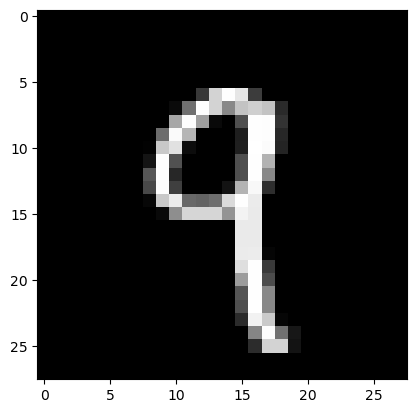

Label: 9


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class Encoder(nn.Module):
    def __init__(self, ResidualBlock, batch_size, L_dim):
        super(Encoder, self).__init__()
        
        pixels = 28**2
        pixelsd4 = int(pixels/4)
        
        self.resnet = ResidualBlock(1, 1)
        
        self.fc1 = nn.Linear(pixels, pixels)
        self.mp1 = nn.MaxPool1d(2)  # Reducing the pooling kernel size to avoid collapsing dimensions
        self.bn1 = nn.BatchNorm1d(pixels//2)  # Updated to match new output shape after pooling
        self.fc2 = nn.Linear(pixels//2, L_dim)  # Adjusted to match output size from BatchNorm1d
        
    def forward(self, x):
        x = self.resnet(x)
        x = torch.reshape(x, [x.shape[0], 28**2])  # Use dynamic batch size instead of hardcoded batch_size
        
        x = self.fc1(x)
        x = x.unsqueeze(1)  # Adding a channel dimension to match MaxPool1d input requirements
        
        x = self.mp1(x)
        x = x.squeeze(1)  # Removing the channel dimension post-pooling
        x = self.bn1(x)
        
        x = self.fc2(x)
        return x  # This is the latent space z as a vector [batch_size, L_dim]
    
    
class Decoder(nn.Module): 
        def __init__(self, L_dim):
            super(Decoder, self).__init__()
            
            self.fc1 = nn.Linear(L_dim, 128 )  # [1, L_dim] -> [1, 128]
            self.fc2 = nn.Linear(128, 256)
            self.bn1 = nn.BatchNorm1d(256) 
            
            self.Tconv1 = nn.ConvTranspose2d(1, 1, (2, 2), 2, 2) 
            self.max_pool1 = nn.MaxPool2d(2, 2)
            
            self.fc3 = nn.Linear(196, 400)
            self.fc4 = nn.Linear(400, 784)
            

        def forward(self, x): 
            
            x = self.fc1(x)
            x = self.fc2( F.relu(x) )
            x = self.bn1(x)
            x = F.relu(x)
            
            x = torch.reshape(x, (100, 1, 16, 16))
            x = self.Tconv1(x)
            x = self.max_pool1(x)
            x = F.relu(x)
            
            x = torch.reshape(x, (100, 196))
            x = self.fc3( x )
            x = self.fc4( F.relu(x) )
            x = torch.reshape(x, (100, 1, 28, 28)) # remove batch size hard-coding

            return x # The reconstruction
        
class AutoEncoder(nn.Module):
    def __init__(self, ResidualBlock, Encoder, Decoder, batch_size, L_dim = 32): 
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder(ResidualBlock, batch_size, L_dim)
        self.decoder = Decoder(L_dim)
        
    def forward(self, x): 
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [13]:
def train(model, train_loader, epochs, opt):
    # Loss stuff
    lr = 1e-4
    weight_decay = 1e-5
    if opt == True:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay = weight_decay)
        
    mse = nn.MSELoss()
    L1 = nn.L1Loss()
    alpha = 0.75
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss") 
#     plt.ylim(0, 100) # A guess
    
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
            
        for data, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = alpha * mse(outputs, data ) + (1 - alpha) * L1(outputs, data )
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        plt.scatter(epoch, running_loss, color = 'r')
        print(f'Epoch [{epoch +1}/{epochs}], Loss: {running_loss:.4f}')

        if epoch%10 ==0: 
            # Additional information
            PATH = "model.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                }, PATH)
    

Epoch [1/50], Loss: 42.4439
Epoch [2/50], Loss: 27.4001
Epoch [3/50], Loss: 23.2269
Epoch [4/50], Loss: 20.8577
Epoch [5/50], Loss: 19.3005
Epoch [6/50], Loss: 18.2338
Epoch [7/50], Loss: 17.5087
Epoch [8/50], Loss: 16.9349
Epoch [9/50], Loss: 16.4998
Epoch [10/50], Loss: 16.1504
Epoch [11/50], Loss: 15.8154
Epoch [12/50], Loss: 15.5663
Epoch [13/50], Loss: 15.3193
Epoch [14/50], Loss: 15.0900
Epoch [15/50], Loss: 14.9114
Epoch [16/50], Loss: 14.7212
Epoch [17/50], Loss: 14.5350
Epoch [18/50], Loss: 14.3989
Epoch [19/50], Loss: 14.2762
Epoch [20/50], Loss: 14.1207
Epoch [21/50], Loss: 14.0024
Epoch [22/50], Loss: 13.8998
Epoch [23/50], Loss: 13.7732
Epoch [24/50], Loss: 13.6767
Epoch [25/50], Loss: 13.5638
Epoch [26/50], Loss: 13.4788
Epoch [27/50], Loss: 13.3968
Epoch [28/50], Loss: 13.2859
Epoch [29/50], Loss: 13.2086
Epoch [30/50], Loss: 13.1241
Epoch [31/50], Loss: 13.0498
Epoch [32/50], Loss: 12.9564
Epoch [33/50], Loss: 12.9064
Epoch [34/50], Loss: 12.8403
Epoch [35/50], Loss: 12

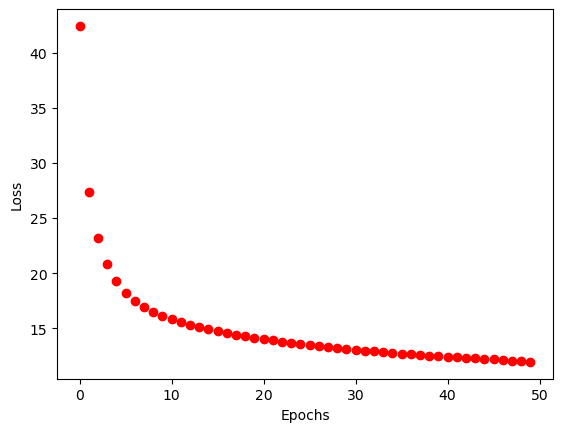

In [15]:
epochs = 50
model = AutoEncoder(ResidualBlock, Encoder, Decoder, batch_size).to(device)
train(model, train_dataloader, epochs, True)

torch.Size([100, 1, 28, 28])


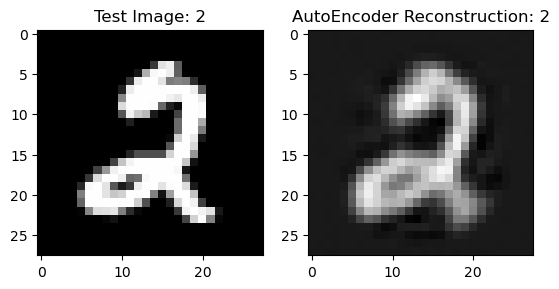

In [27]:
test_features, test_labels = next(iter(test_dataloader))
print(test_features.shape)
recon = model(test_features)[0]

true = test_features[0].squeeze()
recon = torch.reshape(recon, (28,28))
recon = recon.detach().numpy()
# recon = (recon/recon.max()).detach().numpy() # Unnecessary scaling

label = int( test_labels[0] )

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Test Image: '+str(  label  ) )
ax1.imshow(true, cmap="gray")

ax2.set_title('AutoEncoder Reconstruction: '+str(  label  ) ) 
ax2.imshow(recon, cmap="gray")
